<a href="https://colab.research.google.com/github/ykato27/PyPortfolioOpt/blob/main/PyPortfolioOpt_Mean_Variance_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mean-variance optimization
In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimization is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

Downloading data and getting it into PyPortfolioOpt
Calculating and visualising the covariance matrix
Optimising a long/short portfolio to minimise total variance
Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
Optimising a market-neutral portfolio to minimise risk for a given level of return
Optimising along the mean-semivariance frontier
Optimising along the mean-CVaR frontier
Plotting the efficient frontier:
Simple (using CLA)
Constrained
Complex plots
Please consult the docs for more info.

In [1]:
!pip install PyPortfolioOpt
!pip install yfinance

     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 1.3MB 11.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736174 sha256=48105e92b4065aa2efa3ba02d6699704a24da1058ccf554f5381640c4d3b7d45
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 6.3MB 10.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=35b7be97f87c36ecced89e5dc75b56af62ca80449e5cc93871229486c2308ea9
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
 

### Downloading data
To download data, we will use yfinance, an excellent library that provides free price data from Yahoo Finance, no API key needed.

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"]

In [4]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  15 of 15 completed


In [5]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2021-06-25,294.660004,3401.459961,394.510010,178.350006,15.19,67.879997,154.050003,54.320000,54.549999,379.609985,265.019989,38.980000,671.869995,404.950012,64.660004
2021-06-28,293.899994,3443.889893,396.540009,176.570007,14.96,67.699997,154.330002,54.259998,53.230000,367.679993,268.720001,39.119999,688.719971,401.459991,63.009998
2021-06-29,296.429993,3448.139893,398.790009,173.929993,15.01,67.930000,154.139999,53.860001,52.919998,368.000000,271.399994,39.099998,680.760010,398.100006,62.619999
2021-06-30,294.790009,3440.159912,395.670013,175.770004,14.86,68.860001,155.539993,54.110001,53.090000,365.089996,270.899994,39.160000,679.700012,400.440002,63.080002
2021-07-01,300.000000,3432.969971,394.529999,177.259995,14.91,69.129997,157.080002,53.959999,53.860001,370.709991,271.600006,39.560001,677.919983,404.890015,63.259998


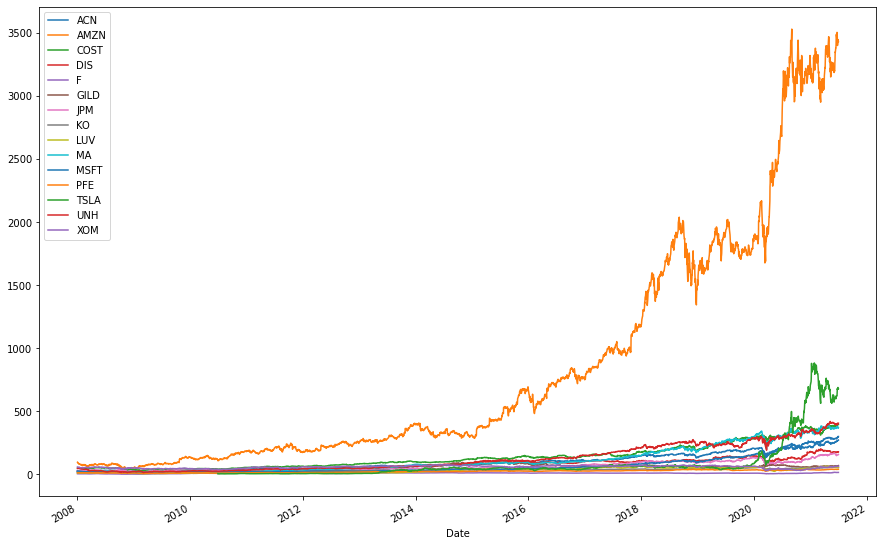

In [6]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

### Calculating the covariance matrix

In [7]:
import pypfopt
pypfopt.__version__

'1.4.2'

In [8]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
ACN,0.091489,0.044592,0.027184,0.040538,0.042967,0.029501,0.049028,0.020347,0.036845,0.045436,0.040381,0.025961,0.039327,0.030459,0.030982
AMZN,0.044592,0.338863,0.047389,0.054478,0.051761,0.060334,0.067086,0.020209,0.047131,0.056273,0.071959,0.032102,0.056704,0.035147,0.026816
COST,0.027184,0.047389,0.102271,0.031952,0.031017,0.027473,0.039047,0.021178,0.031529,0.032281,0.036974,0.025585,0.023543,0.027450,0.020670
DIS,0.040538,0.054478,0.031952,0.099593,0.040108,0.032903,0.047241,0.026307,0.038779,0.049967,0.042505,0.029812,0.036043,0.032362,0.025547
F,0.042967,0.051761,0.031017,0.040108,0.125291,0.030362,0.054355,0.026335,0.045474,0.062239,0.040895,0.027518,0.048860,0.029276,0.027411
GILD,0.029501,0.060334,0.027473,0.032903,0.030362,0.241198,0.043355,0.016827,0.031596,0.033637,0.035961,0.032967,0.033438,0.034607,0.021565
JPM,0.049028,0.067086,0.039047,0.047241,0.054355,0.043355,0.129771,0.028028,0.048972,0.071478,0.049765,0.033271,0.039331,0.039090,0.033203
KO,0.020347,0.020209,0.021178,0.026307,0.026335,0.016827,0.028028,0.054033,0.023198,0.026443,0.028010,0.026362,0.019089,0.023068,0.020869
LUV,0.036845,0.047131,0.031529,0.038779,0.045474,0.031596,0.048972,0.023198,0.138740,0.047718,0.036810,0.026517,0.035315,0.033116,0.023192
MA,0.045436,0.056273,0.032281,0.049967,0.062239,0.033637,0.071478,0.026443,0.047718,0.119682,0.049220,0.033512,0.046822,0.044016,0.042953


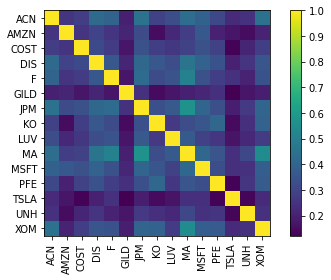

In [9]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

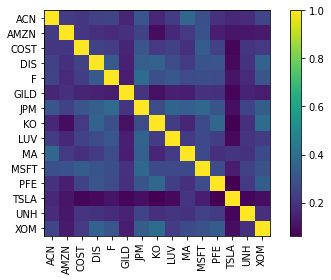

In [10]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

### Return estimation
As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the min_volatility() portfolio or use HRP.

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook 1-RiskReturnModels.ipynb for more information.

In [11]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

ACN     0.210979
AMZN    0.362479
COST    0.196775
DIS     0.225789
F       0.225420
GILD    0.260555
JPM     0.255479
KO      0.150104
LUV     0.229384
MA      0.266102
MSFT    0.241681
PFE     0.181133
TSLA    0.283164
UNH     0.224274
XOM     0.142658
Name: mkt, dtype: float64

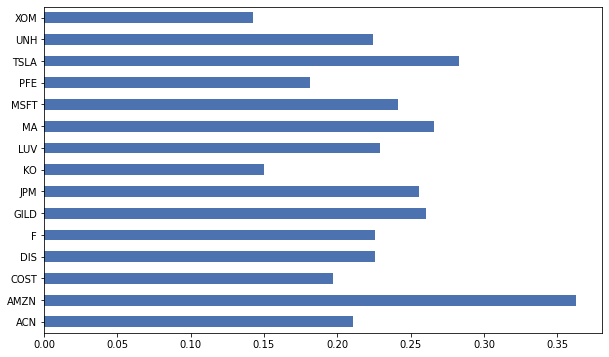

In [12]:
mu.plot.barh(figsize=(10,6));

### Long/short min variance
In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [13]:
from pypfopt import EfficientFrontier

In [14]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.23414),
             ('AMZN', 0.00849),
             ('COST', 0.09868),
             ('DIS', -0.01608),
             ('F', -0.01623),
             ('GILD', 0.04236),
             ('JPM', -0.05082),
             ('KO', 0.12306),
             ('LUV', 0.024),
             ('MA', 0.23743),
             ('MSFT', 0.00231),
             ('PFE', 0.06324),
             ('TSLA', 0.14505),
             ('UNH', 0.03043),
             ('XOM', 0.07395)])

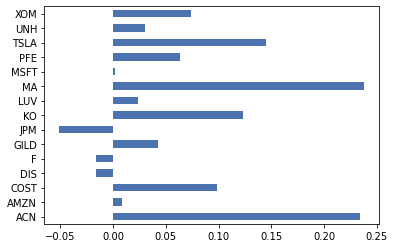

In [15]:
pd.Series(weights).plot.barh();

In [16]:
ef.portfolio_performance(verbose=True);

Annual volatility: 11.8%


In [17]:
prices

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,0.058398,NaN,NaN,NaN,0.051918,NaN,NaN,NaN,NaN,NaN,NaN,0.105947
1962-01-03,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.050762,NaN,NaN,NaN,NaN,NaN,NaN,0.107521
1962-01-04,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.051147,NaN,NaN,NaN,NaN,NaN,NaN,0.107783
1962-01-05,NaN,NaN,NaN,0.059378,NaN,NaN,NaN,0.049991,NaN,NaN,NaN,NaN,NaN,NaN,0.105423
1962-01-08,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.049477,NaN,NaN,NaN,NaN,NaN,NaN,0.105161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,294.660004,3401.459961,394.510010,178.350006,15.19,67.879997,154.050003,54.320000,54.549999,379.609985,265.019989,38.980000,671.869995,404.950012,64.660004
2021-06-28,293.899994,3443.889893,396.540009,176.570007,14.96,67.699997,154.330002,54.259998,53.230000,367.679993,268.720001,39.119999,688.719971,401.459991,63.009998
2021-06-29,296.429993,3448.139893,398.790009,173.929993,15.01,67.930000,154.139999,53.860001,52.919998,368.000000,271.399994,39.099998,680.760010,398.100006,62.619999


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares. To do this, we would need to construct a discrete allocation (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [18]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $42.11 leftover


{'ACN': 15,
 'COST': 5,
 'DIS': -7,
 'F': -76,
 'GILD': 11,
 'JPM': -23,
 'KO': 42,
 'LUV': 8,
 'MA': 12,
 'PFE': 29,
 'TSLA': 4,
 'UNH': 1,
 'XOM': 21}

### Max Sharpe with sector constraints
If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A sector_mapper, your sector_lower bounds, and your sector_upper bounds.

In [19]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

We then set up the optimizer and add our constraints. We can use ef.add_objective() to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA

In [20]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [21]:
weights

OrderedDict([('ACN', 0.16981),
             ('AMZN', 0.1),
             ('COST', 0.05569),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06062),
             ('JPM', 0.0),
             ('KO', 0.04431),
             ('LUV', 0.02064),
             ('MA', 0.39519),
             ('MSFT', 0.05),
             ('PFE', 0.0213),
             ('TSLA', 0.05),
             ('UNH', 0.03244),
             ('XOM', 0.0)])

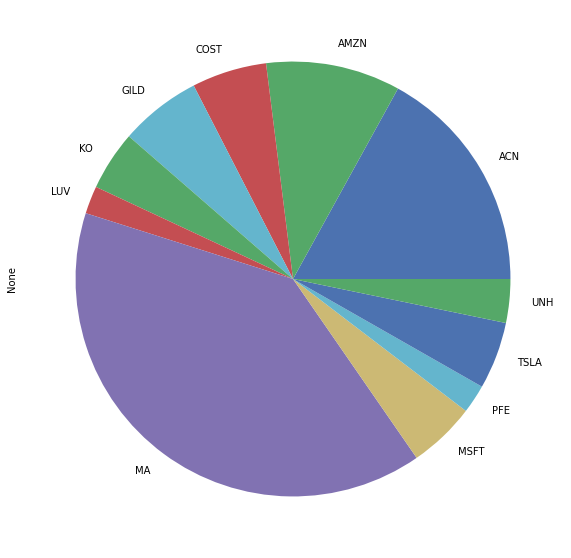

In [22]:
pd.Series(weights).plot.pie(figsize=(10,10));

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:

In [23]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Tech: 0.050
Energy: 0.000
Financial Services: 0.395
Consumer Staples: 0.100
Misc: 0.170
Auto: 0.050
Media: 0.000
Aerospace: 0.021
Consumer Discretionary: 0.100
Healthcare: 0.114


### Maximise return for a given risk, with L2 regularisation
Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [24]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.0),
             ('AMZN', 0.19301),
             ('COST', 0.1),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.05857),
             ('JPM', 0.0),
             ('KO', 0.0),
             ('LUV', 0.0),
             ('MA', 0.44842),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.0),
             ('XOM', 0.0)])

In [25]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

9/15 tickers have zero weight


In [26]:
ef.portfolio_performance(verbose=True);

Expected annual return: 27.9%
Annual volatility: 15.0%
Sharpe Ratio: 1.73



While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimizer is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use L2 regularisation – essentially, adding a penalty on the number of near-zero weights.

In [27]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.04578),
             ('AMZN', 0.20792),
             ('COST', 0.0896),
             ('DIS', 0.01115),
             ('F', 0.0),
             ('GILD', 0.08367),
             ('JPM', 0.04447),
             ('KO', 0.0104),
             ('LUV', 0.02793),
             ('MA', 0.2458),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.03328),
             ('XOM', 0.0)])

In [28]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight



We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation.

In [29]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.05547),
             ('AMZN', 0.13122),
             ('COST', 0.06167),
             ('DIS', 0.06287),
             ('F', 0.06056),
             ('GILD', 0.08025),
             ('JPM', 0.07772),
             ('KO', 0.03833),
             ('LUV', 0.06467),
             ('MA', 0.08303),
             ('MSFT', 0.07082),
             ('PFE', 0.04054),
             ('TSLA', 0.08944),
             ('UNH', 0.06211),
             ('XOM', 0.02131)])

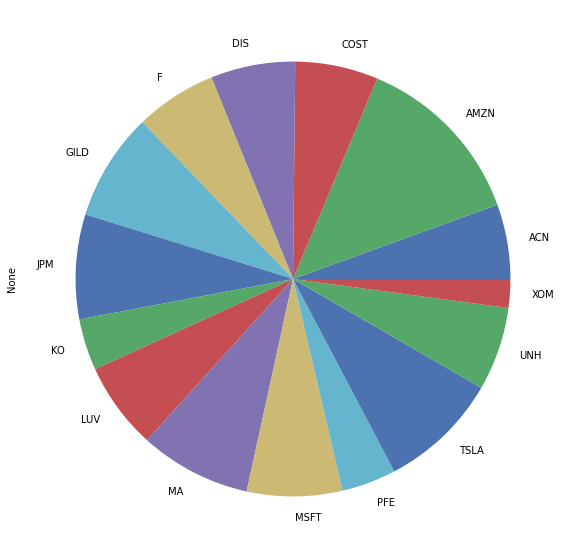

In [30]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [31]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.9%
Annual volatility: 14.8%
Sharpe Ratio: 1.55


The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment.

### Minimise risk for a given return, market-neutral
We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.

In [32]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', -0.03561),
             ('AMZN', 0.21711),
             ('COST', -0.05906),
             ('DIS', -0.00419),
             ('F', -0.00628),
             ('GILD', 0.0492),
             ('JPM', 0.04503),
             ('KO', -0.13762),
             ('LUV', -0.00045),
             ('MA', 0.06454),
             ('MSFT', 0.0195),
             ('PFE', -0.083),
             ('TSLA', 0.09222),
             ('UNH', -0.00868),
             ('XOM', -0.15272)])

In [33]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 10.5%
Sharpe Ratio: 0.48


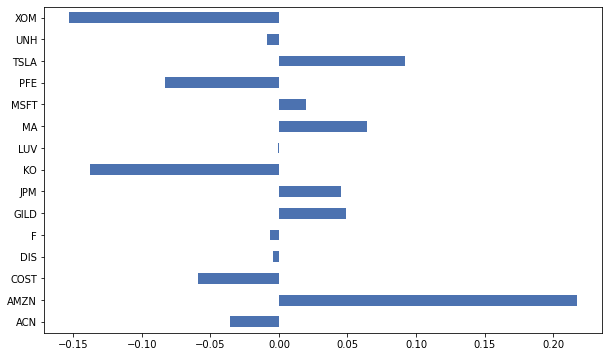

In [34]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [35]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: -0.00


### Efficient semi-variance optimization
In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into EfficientFrontier (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).

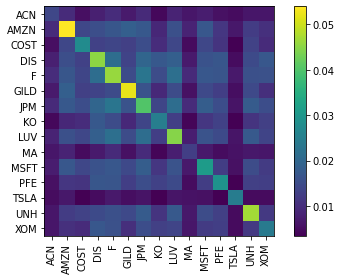

In [36]:
semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

In [37]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.25584),
             ('AMZN', 0.0),
             ('COST', 0.08766),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.00766),
             ('JPM', 0.0),
             ('KO', 0.12849),
             ('LUV', 0.0),
             ('MA', 0.31329),
             ('MSFT', 0.0),
             ('PFE', 0.04797),
             ('TSLA', 0.15061),
             ('UNH', 0.0),
             ('XOM', 0.00847)])

In [38]:
ef.portfolio_performance(verbose=True);

Expected annual return: 22.8%
Annual volatility: 8.9%
Sharpe Ratio: 2.35


In [39]:
returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

In [40]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual semi-deviation: 10.2%
Sortino Ratio: 1.76


To compare this with the heuristic solution, I will use a quick hack: replacing the es.weights with es.weights and running es.portfolio_performance again. Please don't be encouraged to do this in real life!

In [41]:
es.weights = ef.weights
es.portfolio_performance(verbose=True);

Expected annual return: 22.8%
Annual semi-deviation: 14.2%
Sortino Ratio: 1.47


### Efficient CVaR optimization
In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.

In [42]:
returns = expected_returns.returns_from_prices(prices).dropna()
returns.head()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2010-06-30,0.000000,0.005985,-0.014381,-0.024768,0.020243,-0.019731,-0.012143,-0.004173,0.000000,-0.017045,-0.012870,-0.001400,-0.002512,-0.008034,-0.003840
2010-07-01,-0.009573,0.015559,0.001276,-0.000317,0.048611,-0.004084,-0.013129,-0.001796,-0.010802,0.016652,0.006519,-0.002104,-0.078472,-0.019366,-0.008060
2010-07-02,-0.008882,-0.016402,-0.012204,-0.003493,-0.027436,0.021382,-0.006929,0.000399,-0.021838,0.000345,0.004749,-0.006325,-0.125683,0.016158,-0.000707
2010-07-06,0.012388,0.008430,-0.004242,0.010835,-0.011673,-0.002867,0.013955,0.007593,-0.011163,-0.013513,0.023636,0.010608,-0.160938,0.020848,0.015733
2010-07-07,0.022129,0.030620,0.005371,0.044767,0.042323,0.004889,0.050096,0.020623,0.062088,0.037694,0.020151,0.023093,-0.019243,0.010730,0.016881


In [43]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 25.7%
Annual volatility: 12.8%
Sharpe Ratio: 1.85


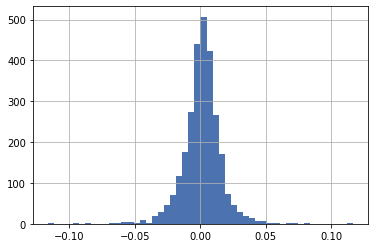

In [44]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

In [45]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.16%
CVaR: -3.31%


This value of the CVaR means that our average loss on the worst 5% of days will be -3.35%. Let's say that this were beyond our comfort zone (for a \$100,000 portfolio, this would mean losing \\$3350 in a day).

Let's firstly construct the portfolio with the minimum CVaR:

In [46]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 18.2%
Conditional Value at Risk: 2.14%


We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use efficient_risk to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [47]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

Expected annual return: 24.9%
Conditional Value at Risk: 2.50%


We now have similar returns to before (24.7% vs 25.8%), but with a lower tail risk (2.50% CVaR vs 3.35%).

### Plotting - Unconstrained
To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm.

In [48]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 25.4%
Annual volatility: 12.7%
Sharpe Ratio: 1.84


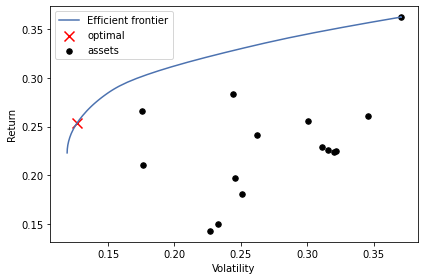

In [49]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

### Plotting - Constrained
In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to MSFT, AMZN, and TSLA (e.g maybe we want to avoid big tech).

In [50]:
import cvxpy as cp

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "TSLA"} for t in tickers]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

As per the docs, before we call any optimization function, we should pass this to the plotting module:

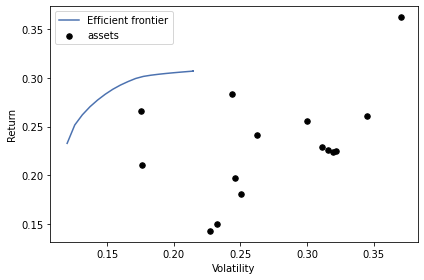

In [51]:
ax = plotting.plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.12, 0.4, 50), 
                                      showfig=False);

### Complex plots
The plotting module allows you to pass in an ax, on top of which the plots are added. This allows you to build complex plots.

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios.

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):

In [52]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.24646514 0.21514594 0.22023875 ... 0.22880419 0.23115198 0.23719165]
Sample portfolio volatilities: 0       0.150028
1       0.144460
2       0.150220
3       0.155745
4       0.143404
          ...   
9995    0.173928
9996    0.146797
9997    0.157143
9998    0.163827
9999    0.191853
Length: 10000, dtype: float64


Note that the above code is equivalent to generating samples via a for loop (just more efficient)



In [53]:
# mus = []
# stds = []
# sharpes = []
# for _ in range(10000):
#     w = np.random.dirichlet(np.ones(len(mu)))
#     # w = np.random.rand(len(mu))
#     # w /= w.sum()
#     ret = mu.dot(w)
#     std = np.sqrt(w.dot(S @ w))
#     mus.append(ret)
#     stds.append(std)
#     sharpes.append(ret / std)

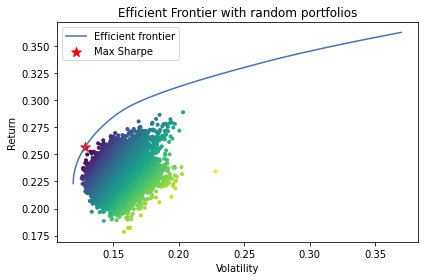

In [54]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()